In [1]:
import os
import cv2

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display

import pandas as pd
import numpy as np

from PIL import Image

from skimage.feature import hog
from skimage import color

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc

In [2]:
labels = pd.read_csv('./dataset/dataset.csv', index_col=0)
labels.head()

,img_file,classification,no_of_contours,processed_img,diagnosis
id,,,,,
1,./dataset/train_img/raw_img/intra1.jpg,healthy,2,./dataset/train_img/processed_img/closed_img/i...,0
2,./dataset/train_img/raw_img/intra2.jpg,gingivitis,5,./dataset/train_img/processed_img/closed_img/i...,1
3,./dataset/train_img/raw_img/intra3.jpg,healthy,2,./dataset/train_img/processed_img/closed_img/i...,0
4,./dataset/train_img/raw_img/intra4.jpg,healthy,0,./dataset/train_img/processed_img/closed_img/i...,0
5,./dataset/train_img/raw_img/intra5.jpg,healthy,0,./dataset/train_img/processed_img/closed_img/i...,0


In [3]:
def get_processedimg(row_id, root="./dataset/train_img/processed_img/noise_reduced_img"):

    filename = "intra{}.jpg".format(row_id)
    file_path = os.path.join(root, filename)
    img = Image.open(file_path)
    return np.array(img)

def get_img(row_id, root="./dataset/train_img/raw_img/"):

    filename = "intra{}.jpg".format(row_id)
    file_path = os.path.join(root, filename)
    img = Image.open(file_path)
    return np.array(img)

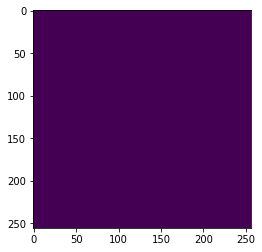

In [4]:
# subset the dataframe to just healthy (diagnosis is 0.0) get the value of the sixth item in the index
healthy_row = labels[labels.diagnosis == 0.0].index[5]

# show the processed image of an healthy gum
plt.imshow(get_processedimg(healthy_row))
plt.show()

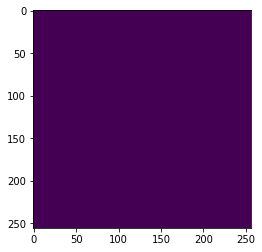

In [5]:
# subset the dataframe to just gingivitis (diagnosis is 1.0) get the value of the sixth item in the index
gingivitis_row = labels[labels.diagnosis == 1.0].index[5]

# show the processed image of an infected gum/gingivitis
plt.imshow(get_processedimg(gingivitis_row))
plt.show()

Color gingivitis image has shape:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


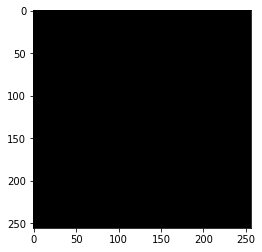

In [6]:
gingi = get_processedimg(gingivitis_row)

print('Color gingivitis image has shape: ', gingi)


plt.imshow(gingi, cmap=mpl.cm.gray)
plt.show()

Greyscale gingivitis image has shape:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


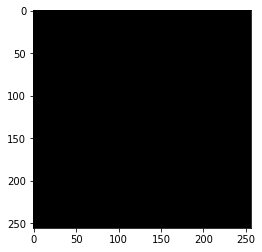

In [7]:
print('Greyscale gingivitis image has shape: ', gingi)

hog_features, hog_image = hog(gingi,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))

plt.imshow(hog_image, cmap=mpl.cm.gray)
plt.show()

In [8]:
def create_features(img):
    # flatten three channel color image
    color_features = img.flatten()
    # get HOG features from greyscale image
    hog_features = hog(img, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    # combine color and hog features into a single array
    flat_features = np.hstack(color_features)
    return flat_features

gingi_features = create_features(gingi)

print(gingi_features)

[0 0 0 ... 0 0 0]


In [9]:
def create_feature_matrix(label_dataframe):
    features_list = []
    
    for img_id in label_dataframe.index:
        # load image
        img = get_processedimg(img_id)
        # get features for image
        image_features = create_features(img)
        features_list.append(image_features)
        
    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix

# run create_feature_matrix on our dataframe of images
feature_matrix = create_feature_matrix(labels)

In [10]:
# get shape of feature matrix
print('Feature matrix shape is: ', feature_matrix.shape)

# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
bees_stand = ss.fit_transform(feature_matrix)

pca = PCA(n_components=500)
# use fit_transform to run PCA on our standardized matrix
gum_pca = ss.fit_transform(bees_stand)
# look at new shape
print('PCA matrix shape is: ', gum_pca.shape)

Feature matrix shape is:  (417, 65536)
PCA matrix shape is:  (417, 65536)


In [11]:
X = pd.DataFrame(gum_pca)
y = pd.Series(labels.diagnosis.values)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.3,
                                                    random_state=1234123)

# look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()

1    179
0    112
dtype: int64

In [35]:
print(X_train.shape)
print(y_train.shape)

(291, 65536)
(291,)


In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras import regularizers
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
# Reshape the input data into 2D images

arr = np.array(X_train).reshape(X_train.shape[0], -1)
X_train = np.array(X_train).reshape((X_train.shape[0], 256, 256, 1))

# Define the model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=97, validation_split=0.2)

# Evaluate the model on the test set
X_test = np.array(X_test).reshape((X_test.shape[0], 256, 256, 1))
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)
predictions = model.predict(X_test)
predictions=[0 if val <0.5 else 1 for val in predictions]
print(predictions)
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))

Epoch 1/5
3/3 [==============================] - 60s 16s/step - loss: 1.6652 - accuracy: 0.5603 - val_loss: 1.2330 - val_accuracy: 0.5085
Epoch 2/5
3/3 [==============================] - 21s 6s/step - loss: 0.6854 - accuracy: 0.5259 - val_loss: 1.2300 - val_accuracy: 0.4915
Epoch 3/5
3/3 [==============================] - 14s 4s/step - loss: 0.5394 - accuracy: 0.5862 - val_loss: 1.7506 - val_accuracy: 0.5593
Epoch 4/5
3/3 [==============================] - 14s 5s/step - loss: 0.5092 - accuracy: 0.6250 - val_loss: 2.3286 - val_accuracy: 0.5932
Epoch 5/5
4/4 [==============================] - 2s 419ms/step - loss: 2.1702 - accuracy: 0.5714
Test accuracy: 0.5714285969734192
4/4 [==============================] - 4s 430ms/step
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [23]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [24]:
y_pred = dt.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.5873015873015873


In [33]:
print('Model accuracy is: ', dt.score(X_test,y_test))

Model accuracy is:  0.5873015873015873


In [25]:
from sklearn. ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=20)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [26]:
y_pred = rf.predict(X_test)
rf.score(X_test,y_test)

0.5793650793650794

In [12]:
# define support vector classifier
svm = SVC(kernel='linear', probability=True, random_state=42)

# fit model
svm.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [13]:
# generate predictions
y_pred = svm.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.5714285714285714


In [18]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#input_dim=X_train.shape[1]

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, input_dim=len(X_train.columns), activation='sigmoid',
                          kernel_constraint=tf.keras.constraints.UnitNorm())
])

# Compile the model with hinge loss and no metrics
model.compile(loss='hinge', optimizer='adam', metrics=['accuracy'])

# Fit the model to the training data
history=model.fit(X_train, y_train, epochs=53   , batch_size=32)

predictions = model.predict(X_test)
#print(predictions, " predictions")
predictions=[0 if val <0.5 else 1 for val in predictions]

from sklearn.metrics import classification_report
 
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions, " accuracy score"))
print(confusion_matrix(y_test, predictions))

# Save the model to disk
#model.save('svm_model1.h5')

Epoch 1/10
10/10 [==============================] - 1s 15ms/step - loss: 0.8499 - accuracy: 0.5326
Epoch 2/10
10/10 [==============================] - 0s 13ms/step - loss: 0.8192 - accuracy: 0.5670
Epoch 3/10
10/10 [==============================] - 0s 12ms/step - loss: 0.8178 - accuracy: 0.5670
Epoch 4/10
10/10 [==============================] - 0s 11ms/step - loss: 0.8124 - accuracy: 0.5739
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 0.8058 - accuracy: 0.5773
Epoch 6/10
10/10 [==============================] - 0s 13ms/step - loss: 0.7972 - accuracy: 0.5876
Epoch 7/10
10/10 [==============================] - 0s 13ms/step - loss: 0.7942 - accuracy: 0.5911
Epoch 8/10
10/10 [==============================] - 0s 14ms/step - loss: 0.7852 - accuracy: 0.6014
Epoch 9/10
10/10 [==============================] - 0s 11ms/step - loss: 0.7808 - accuracy: 0.6048
Epoch 10/10
4/4 [==============================] - 0s 13ms/step
              precision    recall  f1-score  

In [38]:
#img4 = cv2.imread("./dataset/train_img/raw_img/intragingi2.jpg")
#img3 = cv2.resize(img4, (256,256))
#cv2.imwrite('./dataset/train_img/raw_img/intragingi2.jpg',img3)
img2 = cv2.imread("./dataset/train_img/raw_img/intragingi.jpg")
img3 = cv2.resize(img2, (256,256))
cv2.imwrite('./dataset/train_img/raw_img/intragingi.jpg',img3)
img4 = cv2.imread("./dataset/train_img/raw_img/intragingi.jpg")
ORANGE_MIN = np.array([5, 145, 94],np.uint8)
ORANGE_MAX = np.array([8, 255, 255],np.uint8)
#img=cv2.rotate(img2, cv2.ROTATE_90_COUNTERCLOCKWISE)
hsv_img = cv2.cvtColor(img4,cv2.COLOR_BGR2HSV)
frame_threshed = cv2.inRange(hsv_img, ORANGE_MIN, ORANGE_MAX)
kernel = np.ones((10, 10), np.uint8)
closing = cv2.morphologyEx(frame_threshed, cv2.MORPH_CLOSE, kernel, iterations=1)
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)
color_features = opening.flatten()
flat_features = np.hstack(color_features)
ok=flat_features.reshape(1, -1)



In [39]:
print(ok)
predictions1 = model.predict(ok)
print(predictions1[0][0], " predictions")
predictions1=[0 if val <0.5 else 1 for val in predictions1]
#if predictions1[0][0]<0.5:
    #print('0')
#else:
    #print('1')
print(predictions1, " predictions1")

[[0 0 0 ... 0 0 0]]
1/1 [==============================] - 0s 59ms/step
1.0  predictions
[1]  predictions1


In [34]:
import tensorflow as tf
from keras.models import load_model
model = load_model('svm_model1.h5')

# Convert the model to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to disk
with open('svm_model.tflite', 'wb') as f:
    f.write(tflite_model)



INFO:tensorflow:Assets written to: C:\Users\Ben\AppData\Local\Temp\tmpiqq6xki_\assets


In [43]:
import cv2
# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path='svm_model.tflite')
interpreter.allocate_tensors()

img2 = cv2.imread("./dataset/train_img/raw_img/intragingi2.jpg")
img3 = cv2.resize(img2, (256,256))
cv2.imwrite('./dataset/train_img/raw_img/intragingi2.jpg',img3)
img4 = cv2.imread("./dataset/train_img/raw_img/intragingi2.jpg")
ORANGE_MIN = np.array([5, 145, 94],np.uint8)
ORANGE_MAX = np.array([8, 255, 255],np.uint8)
#img=cv2.rotate(img3, cv2.ROTATE_90_COUNTERCLOCKWISE)
hsv_img = cv2.cvtColor(img4,cv2.COLOR_BGR2HSV)



frame_threshed = cv2.inRange(hsv_img, ORANGE_MIN, ORANGE_MAX)



kernel = np.ones((10, 10), np.uint8)
closing = cv2.morphologyEx(frame_threshed, cv2.MORPH_CLOSE, kernel, iterations=1)
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)
color_features = opening.flatten()
flat_features = np.hstack(color_features)
ok=flat_features.reshape(1, -1)

# Get the input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

#print(output_details[0])
#print(ok.astype(np.float32))

# Define a new input for prediction


# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], ok.astype(np.float32))

# Run the inference
interpreter.invoke()

# Get the output tensor and print the prediction
output_data = interpreter.get_tensor(output_details[0]['index'])
if output_data<0.5:
    print('0')
else:
    print('1')
#print(output_data)

# Print the predicted classes
#predicted_classes = np.argmax(output_data, axis=1)
#print(predicted_classes)

0
